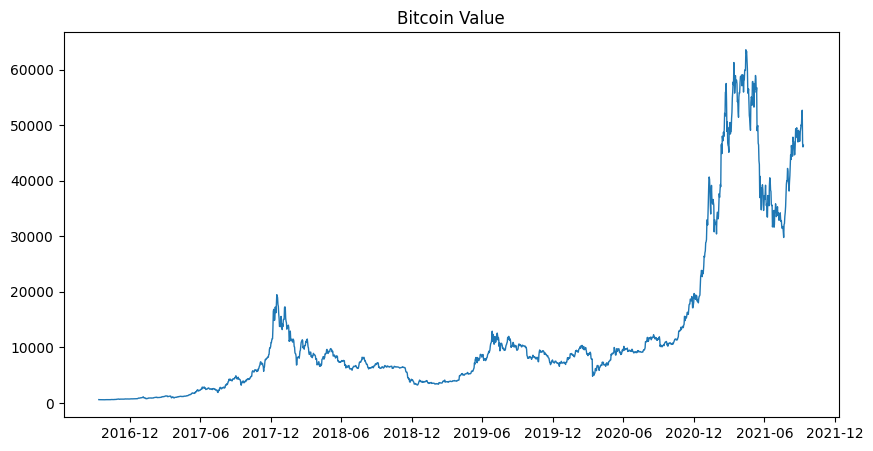

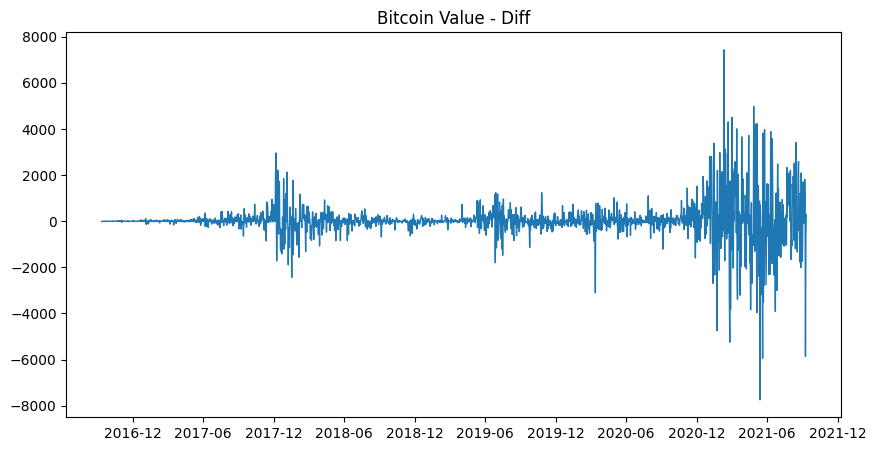

In [20]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
from matplotlib.dates import date2num
from matplotlib.dates import MonthLocator
import matplotlib.pyplot as plt

data = pd.read_csv('2022_Problem_C_DATA/BCHAIN-MKPRU.csv')
input_param_name = 'Date'
output_param_name = 'Value'

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y')
value = data[[output_param_name]].values.flatten()
diff_val = data[[output_param_name]].diff()

plt.gcf().set_size_inches(10, 5)
plt.title("Bitcoin Value")
plt.plot(data['Date'], value, linestyle = '-', linewidth = 1)
plt.gca().xaxis.set_major_locator(MonthLocator(interval=6))
plt.show()

plt.gcf().set_size_inches(10, 5)
plt.title("Bitcoin Value - Diff")
plt.plot(data['Date'], diff_val, linestyle = '-', linewidth = 1)
plt.gca().xaxis.set_major_locator(MonthLocator(interval=6))
plt.show()

In [21]:
data = pd.read_csv('2022_Problem_C_DATA/LBMA-GOLD.csv')
input_param_name = 'Date'
output_param_name = 'USD (PM)'

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y')
value = data[[output_param_name]].values.flatten()
diff_val = data[[output_param_name]].diff()

plt.gcf().set_size_inches(10, 5)
plt.plot(data['Date'], value, linestyle = '-', linewidth = 1)
plt.title("Gold value")
plt.gca().xaxis.set_major_locator(MonthLocator(interval=6))
plt.show()

plt.gcf().set_size_inches(10, 5)
plt.title("Gold Value - Diff")
plt.plot(data['Date'], diff_val, linestyle = '-', linewidth = 1)
plt.gca().xaxis.set_major_locator(MonthLocator(interval=6))
plt.show()

KeyError: "None of [Index(['USD (PM)'], dtype='object')] are in the [columns]"

In [22]:
data = pd.read_csv('2022_Problem_C_DATA/BCHAIN-MKPRU.csv',index_col= 'Date', parse_dates=['Date'])

/var/folders/f0/byzm0qjj7f750yfysp4rl_340000gn/T/ipykernel_10270/1137342321.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('2022_Problem_C_DATA/BCHAIN-MKPRU.csv',index_col= 'Date', parse_dates=['Date'])


In [23]:
data.index = pd.to_datetime(data.index)
data['Value']
sub = data.loc['2016-09':'2021-12','Value']
sub.head()

Date
2016-09-11    621.65
2016-09-12    609.67
2016-09-13    610.92
2016-09-14    608.82
2016-09-15    610.38
Name: Value, dtype: float64

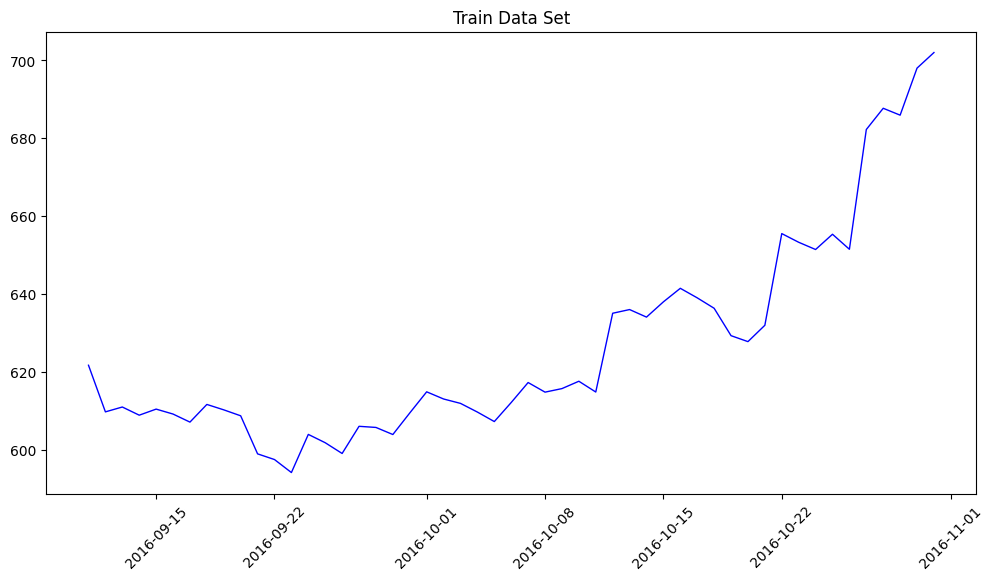

Date
2016-09-11    621.65
2016-09-12    609.67
2016-09-13    610.92
2016-09-14    608.82
2016-09-15    610.38
2016-09-16    609.11
2016-09-17    607.04
2016-09-18    611.58
2016-09-19    610.19
2016-09-20    608.66
2016-09-21    598.88
2016-09-22    597.42
2016-09-23    594.08
2016-09-24    603.88
2016-09-25    601.74
2016-09-26    598.98
2016-09-27    605.96
2016-09-28    605.67
2016-09-29    603.85
2016-09-30    609.39
2016-10-01    614.82
2016-10-02    612.98
2016-10-03    611.85
2016-10-04    609.62
2016-10-05    607.18
2016-10-06    612.08
2016-10-07    617.21
2016-10-08    614.74
2016-10-09    615.65
2016-10-10    617.54
2016-10-11    614.77
2016-10-12    635.01
2016-10-13    635.96
2016-10-14    634.02
2016-10-15    637.94
2016-10-16    641.42
2016-10-17    638.97
2016-10-18    636.29
2016-10-19    629.25
2016-10-20    627.72
2016-10-21    631.92
2016-10-22    655.48
2016-10-23    653.25
2016-10-24    651.39
2016-10-25    655.31
2016-10-26    651.45
2016-10-27    682.22
2016-10-

In [34]:
# 划分训练集 / 测试集
train = sub.loc['2016-09':'2016-10']
pred = sub.loc['2016-10':'2022']
# 查看训练集的时间 / 数据
plt.figure(figsize=(12,6))
plt.plot(train, linewidth = 1, color= 'b')
plt.title("Train Data Set")
plt.xticks(rotation = 45)
plt.show()


In [35]:
 # 差分
data_diff1 = train.diff(1).dropna()
data_diff2 = train.diff(2).dropna()
data['diff_1'] = data['Value'].diff(1)
data['diff_2'] = data['diff_1'].diff(1)

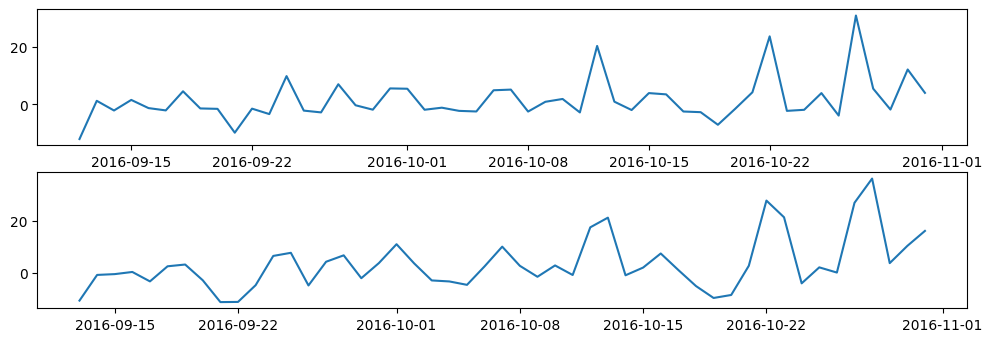

In [36]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(312)
ax1.plot(data_diff1)

ax2 = fig.add_subplot(313)
ax2.plot(data_diff2)

plt.show()

# ADF

In [38]:
import pandas as pd
import statsmodels.api as stm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF

#计算原始序列，一阶差分，二阶差分序列的单位根检验结果
data_diff1 = data_diff1.fillna(0) #填补缺失值
data_diff2 = data_diff2.fillna(0)

timeseries_adf = ADF(train)
timeseries_diff1_adf = ADF(data_diff1)
timeseries_diff2_adf = ADF(data_diff2)

print("p_timeseries:", timeseries_adf)
print("p_diff1series:", timeseries_diff1_adf)
print("p_diff2series:", timeseries_diff2_adf)
# Choose d=1

p_timeseries: (2.7443897668182577, 1.0, 4, 46, {'1%': -3.5812576580093696, '5%': -2.9267849124681518, '10%': -2.6015409829867675}, 272.3124848478031)
p_diff1series: (-7.402210308244168, 7.503552559825255e-11, 0, 49, {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}, 266.5772454162166)
p_diff2series: (-1.0370698799010114, 0.7395050245573667, 5, 43, {'1%': -3.5925042342183704, '5%': -2.931549768951162, '10%': -2.60406594375338}, 267.9272515241886)


- 一次差分后结果通过稳定性检验，d取1

## 白噪声检验

# 确定参数 （p,q）

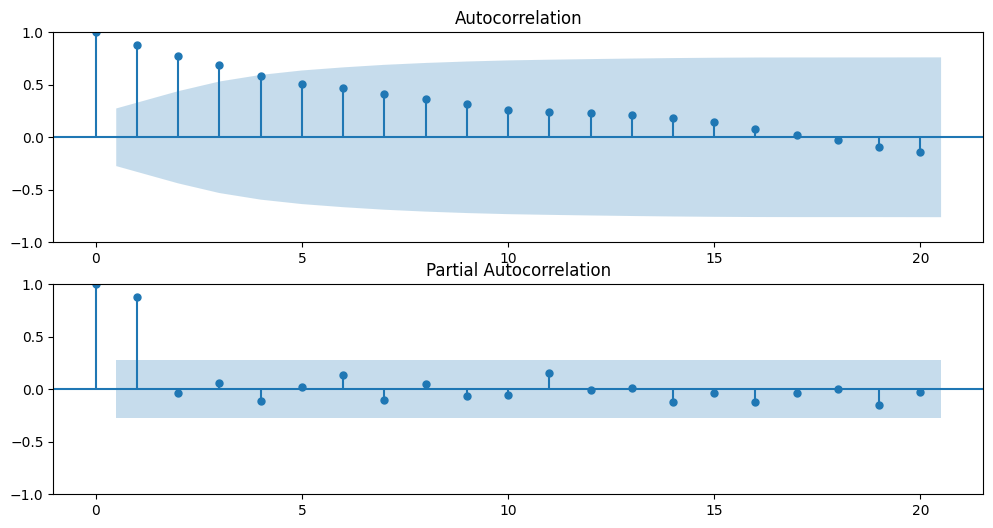

In [41]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(211)
fig = stm.graphics.tsa.plot_acf(train, lags = 20, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')

ax2 = fig.add_subplot(212)
fig = stm.graphics.tsa.plot_pacf(train, lags = 20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')

plt.show()


In [47]:
import itertools
import seaborn as sns

p_min = 0
d_min = 1
q_min = 0
p_max = 9
d_max = 1
q_max = 9

In [48]:
# Initialise a dataframe for results storage, using BIC
result_bic = pd.DataFrame(index = ['AR{}'.format(i) for i in range(p_min,p_max+1)],
                          columns = ['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p == 0 and d == 0 and q == 0:
        result_bic.loc['AR{}'.format(p),'MA{}'.format(q)] = np.nan
        continue
    try:
        model = stm.tsa.ARIMA(data_diff1,order=(p,d,q))
        result = model.fit()
        result_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = result.bic
    except:
        continue

/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, 

In [49]:
result_bic

,MA0,MA1,MA2,MA3,MA4,MA5,MA6,MA7,MA8,MA9
AR0,374.205798,345.885908,348.947069,350.926576,354.709322,356.090642,357.932583,361.63391,363.604674,367.403827
AR1,365.348754,349.236296,352.69154,353.960108,357.651483,359.217451,361.770165,365.078945,367.517332,371.337224
AR2,359.932745,351.84095,354.455922,357.26537,358.812861,358.297767,362.108969,365.891182,367.173932,369.716369
AR3,362.783896,355.688768,358.297289,359.754771,361.22897,362.105811,364.371597,368.62697,371.464961,373.291195
AR4,353.127207,354.290761,357.622969,358.590168,360.441405,364.603358,368.149018,372.158579,375.774088,377.199376
AR5,353.909135,358.039259,361.607136,364.016476,365.587724,373.644598,369.63759,373.827867,377.648299,382.316819
AR6,357.797049,361.121629,364.961426,364.310246,368.362621,372.048606,373.346111,377.224939,381.095762,384.649118
AR7,361.268709,364.788794,367.231099,366.780483,371.996429,375.404211,377.279482,380.223469,379.956384,388.621839
AR8,362.951286,365.677775,368.930994,372.569303,376.050629,379.100809,381.894273,385.315001,388.909761,392.855208
AR9,364.716931,368.191389,373.461233,376.3787,375.818741,379.124191,385.285743,385.973106,391.340872,397.591737


In [50]:
result_bic = result_bic[result_bic.columns].astype(float)

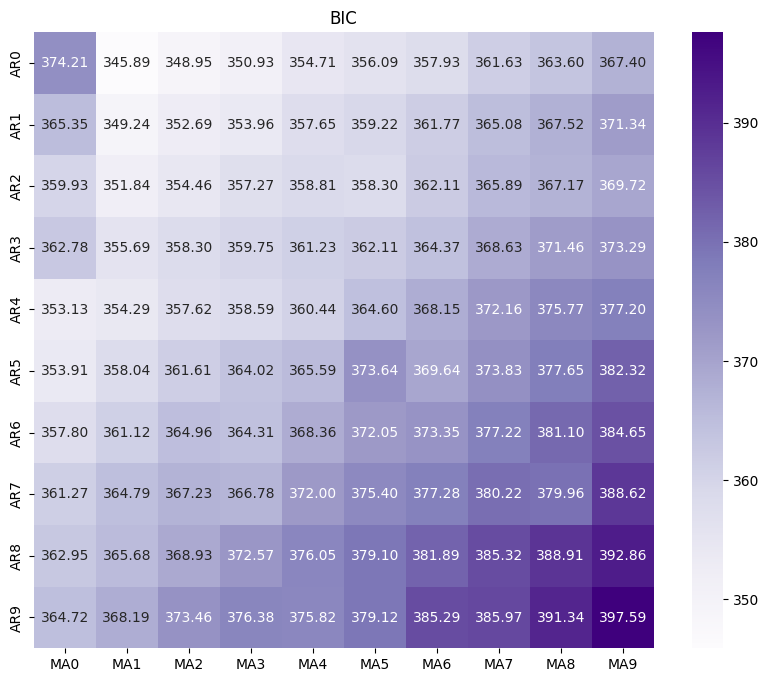

In [51]:
fig,ax = plt.subplots(figsize = (10,8))
ax = sns.heatmap(result_bic,
                 mask=result_bic.isnull(),
                 ax = ax,
                 annot = True,
                 fmt = '.2f',
                 cmap = 'Purples')
ax.set_title('BIC')
plt.show()

In [52]:
result_bic.stack().idxmin()

('AR0', 'MA1')

In [53]:
train_results = stm.tsa.arma_order_select_ic(data_diff1,ic = ['aic','bic'], trend='n', max_ar=10, max_ma = 10)

print(train_results.aic_min_order)
print(train_results.bic_min_order)

/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aiden/micromamba/lib/p

(0, 0)
(0, 0)


/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [54]:
p = 6
q = 9
d = 1

model = stm.tsa.ARIMA(train, order=(p,d,q))
result = model.fit()
resit = result.resid

/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: Use

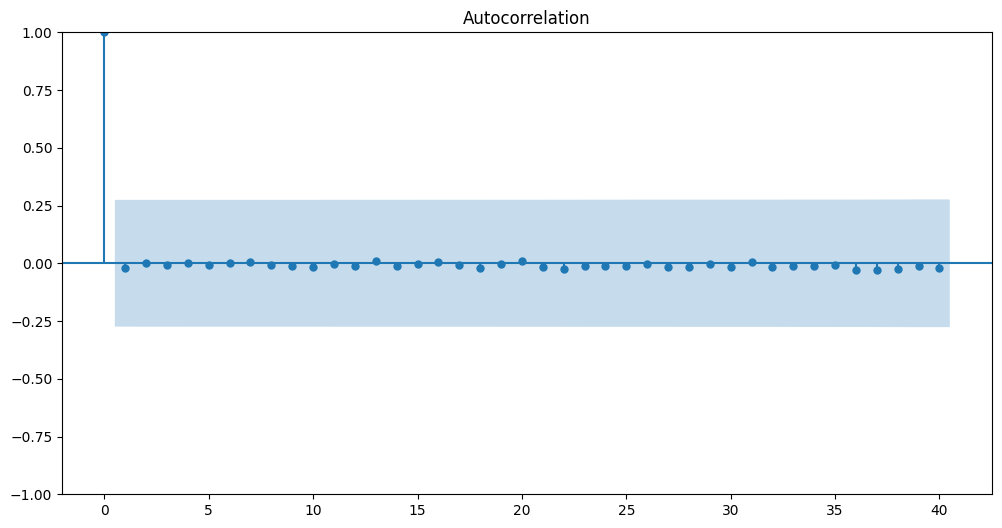

In [55]:
fig, ax = plt.subplots(figsize = (12,6))
ax = stm.graphics.tsa.plot_acf(resit, lags=40, ax=ax)
plt.show()

In [56]:
predict = result.predict(dynamic=False)
print(predict)

2016-09-11      0.000000
2016-09-12    621.654543
2016-09-13    608.297393
2016-09-14    610.267221
2016-09-15    606.666868
2016-09-16    610.925521
2016-09-17    603.353833
2016-09-18    604.447591
2016-09-19    612.234401
2016-09-20    611.408525
2016-09-21    605.946313
2016-09-22    595.506415
2016-09-23    597.926721
2016-09-24    594.955528
2016-09-25    603.282072
2016-09-26    597.434178
2016-09-27    596.879565
2016-09-28    603.752008
2016-09-29    611.285588
2016-09-30    604.830148
2016-10-01    602.303323
2016-10-02    616.239286
2016-10-03    620.856301
2016-10-04    609.118313
2016-10-05    605.993622
2016-10-06    611.554473
2016-10-07    613.039674
2016-10-08    616.480595
2016-10-09    617.892052
2016-10-10    611.996022
2016-10-11    614.902368
2016-10-12    623.627655
2016-10-13    637.078413
2016-10-14    631.734830
2016-10-15    637.075940
2016-10-16    637.989878
2016-10-17    647.651708
2016-10-18    644.935961
2016-10-19    633.112642
2016-10-20    624.223140


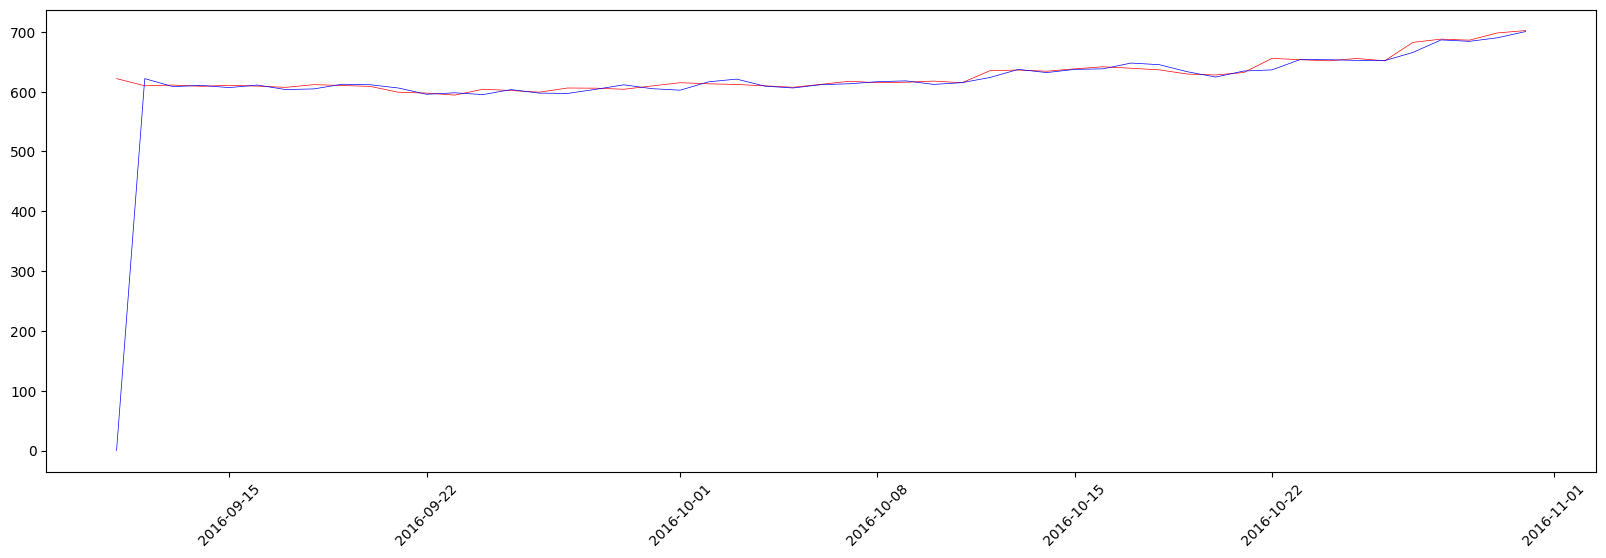

In [57]:
plt.figure(figsize = (20,6))
plt.plot(train, color = 'r', linewidth = 0.5)
plt.xticks(rotation = 45)
plt.plot(predict, color = 'b', linewidth = 0.5)
plt.show()

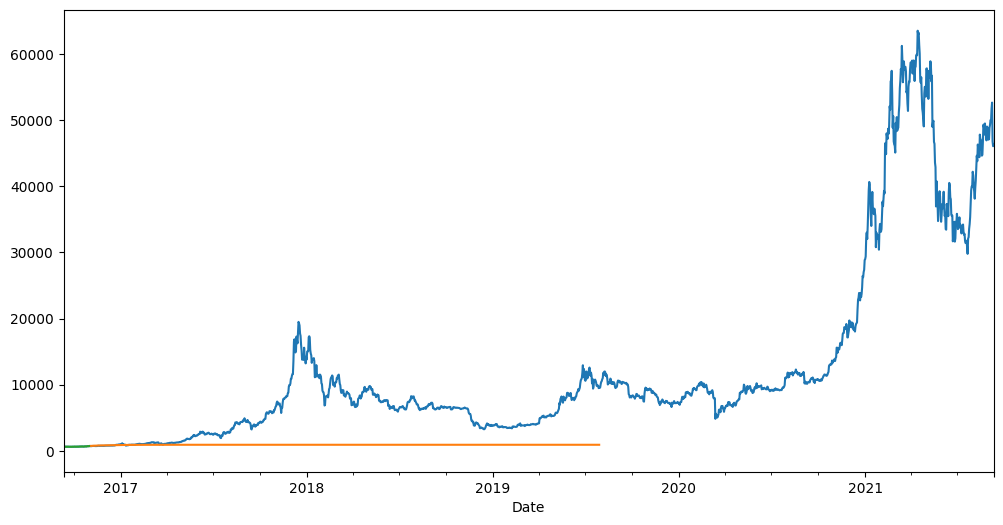

In [59]:
forecast_values = result.predict(start=len(train), end=len(train) + 1000, dynamic=False)
fig,ax = plt.subplots(figsize = (12,6))
ax = sub.plot(ax=ax)
forecast_values.plot(ax=ax)
predict.plot(ax=ax)
plt.show()